<a href="https://www.kaggle.com/code/ahmedrushdi/rl-pong-ddqn?scriptVersionId=122247201" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
!pip install gym[atari,accept-rom-license] #--quiet
!pip install pygame --quiet
!pip install pyvirtualdisplay --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 29.7 MB/s eta 0:00:00
  Installing build dependencies ... - \ | / - \ | / - \ | / - \ done
  Getting requirements to build wheel ... - done
  Preparing metadata (pyproject.toml) ... - done
  Using cached libtorrent-2.0.7-cp37-cp37m-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (8.6 MB)
  Created wheel for AutoROM.accept-rom-license: filename=AutoROM.accept_rom_license-0.5.5-py3-none-any.whl size=448837 sha256=e892e59ac782f8f70f9b95fcb1e3d574fdc06abd4fad8899b9306ad9b101fa6e
  Stored in directory: /root/.cache/pip/wheels/ff/91/f8/f518dfff78fedfb9076d3439fe8b08c03ced911b2fefcd385e
Successfully built AutoROM.accept-rom-license


In [2]:
from pyvirtualdisplay import Display
display = Display(visible=0, size=(1024, 768))
display.start()


from matplotlib import pyplot as plt, animation
%matplotlib inline
from IPython import display

def create_anim(frames, dpi, fps):
    plt.figure(figsize=(frames[0].shape[1] / dpi, frames[0].shape[0] / dpi), dpi=dpi)
    patch = plt.imshow(frames[0])
    def setup():
        plt.axis('off')
    def animate(i):
        patch.set_data(frames[i])
    anim = animation.FuncAnimation(plt.gcf(), animate, init_func=setup, frames=len(frames), interval=fps)
    return anim

def display_anim(frames, dpi=72, fps=50):
    anim = create_anim(frames, dpi, fps)
    return anim.to_jshtml()

def save_anim(frames, filename, dpi=72, fps=50):
    anim = create_anim(frames, dpi, fps)
    anim.save(filename)

In [3]:
from IPython.display import clear_output
import gym
import numpy as np
from tqdm.notebook import tqdm
from tensorflow import keras
import tensorflow as tf
from collections import deque
import random
from keras.backend import int_shape
from tensorflow.keras.models import load_model
import psutil

/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:585: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  np.object,
/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:637: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  np.bool,
/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/tensor_util.py:108: DeprecationWarning: `np.object` is a deprecated ali

In [4]:
env = gym.make('PongNoFrameskip-v4')
env = gym.wrappers.AtariPreprocessing(env, noop_max=30, frame_skip=4, screen_size=84, terminal_on_life_loss=False, grayscale_obs=True, grayscale_newaxis=False, scale_obs=True)
env = gym.wrappers.FrameStack(env, 4)

A.L.E: Arcade Learning Environment (version 0.7.5+db37282)
[Powered by Stella]


In [5]:
env.action_space

Discrete(6)

In [6]:
env.observation_space

Box(0.0, 1.0, (4, 84, 84), float32)

In [7]:
# number of frames to run
NUM_FRAMES = 4000000

#number of episodes to run
NUM_EPISODES = 100

#initial episode to continue training (0 if didn't train)
INIT_EPISODE = 500

#max iterations per run
MAX_ITERATIONS = 1000


#epsilon for choosing action
eps = 1 
eps_decay = 0.99

eps = eps*(eps_decay**INIT_EPISODE)

#discount factor for future utility
discount_factor = 0.97

#batch size for exp replay
batch_size = 32

#max memory stored for exp replay
MAX_MEMORY = int(NUM_FRAMES/40)

#initial population of memory using random policy
INIT_MEMORY = int(MAX_MEMORY*0.8)

#update interval to use target network
TARGET_C = int(NUM_FRAMES/1000)

In [8]:
class DQNAgent:
    def __init__(self, state_size, action_size):
#         import pdb; pdb.set_trace()
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=MAX_MEMORY)
        self.gamma = discount_factor    # discount rate
        self.epsilon = eps  # exploration rate
#         self.epsilon_min = eps_min
        self.epsilon_decay = eps_decay
        self.learning_rate = 0.00025
        self.model = self._build_model()
        self.target_model = self._build_model()
        self.update_target_model()
        
    def update_target_model(self):
        self.target_model.set_weights(self.model.get_weights())
    def _build_model(self):
        model = keras.Sequential(
            [
                keras.layers.Permute((2,3,1), input_shape=self.state_size),
                keras.layers.Conv2D(16, kernel_size=(8, 8), strides=4, activation="relu",),
                keras.layers.Conv2D(32, kernel_size=(4, 4), strides=2, activation="relu"),
                keras.layers.Flatten(),
                keras.layers.Dense(256, activation="relu"),
                keras.layers.Dense(self.action_size, activation="linear"),
            ]
        )
        model.compile(loss='mse',
              optimizer=keras.optimizers.Adam(learning_rate=self.learning_rate))
        return model

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((np.expand_dims(state, axis=0), action, reward, np.expand_dims(next_state, axis=0), done))

    #get action
    def act(self, state):
        #select random action with prob=epsilon else action=maxQ
#         import pdb; pdb.set_trace()
        state = (np.expand_dims(state, axis=0))
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        act_values = self.model.predict(state)
        return np.argmax(act_values)
    
    def replay(self, batch_size):
        #sample random transitions
        
        state, action, reward, next_state, done = zip(*random.sample(self.memory, batch_size))
        state = np.concatenate(state)
        next_state = np.concatenate(next_state)
        action = np.array(action)
        reward = np.array(reward)
        done = np.array(done)
        Q_next=self.model.predict(next_state)
        states_target_q_values = self.target_model.predict(state)
        action_i = (np.arange(batch_size),action)
        n_action_i = (np.arange(batch_size),np.argmax(Q_next, axis=1))
#         import pdb; pdb.set_trace()
        target = reward + self.gamma * Q_next[n_action_i] * (1 - done)
        states_target_q_values[action_i] = target
        self.model.fit(state,states_target_q_values,epochs=1, verbose=0)
        
        
    def train(self, n_episodes, n_iterations):
        
        self.init_mem(INIT_MEMORY)
        scores = []
        iterations = []
        for i in tqdm(range(n_episodes), desc='Episodes'):
            state = env.reset()
            done = False
            score = 0
            frames = 0
            t = tqdm(range(n_iterations), leave=False, desc='iterations', total = 1000)
            for j in t:
                action = self.act(state)
                next_state, reward, done, info = env.step(action)
                self.remember(state, action, reward, next_state, done)
#                 if (j + 1)% (batch_size//4) == 0:
                self.replay(batch_size)
                if j % TARGET_C == 0:
                    
                    self.update_target_model()
                state = next_state
                score += reward
                self.epsilon *= self.epsilon_decay
                if done:
                    t.container.close()
                    iterations.append(j+1)
                    break
            scores.append(score)
            self.save_models()
            print(f'EP{INIT_EPISODE+i}: Done with status n_iter: {j+1}, mem_size: {len(self.memory)} {psutil.virtual_memory()}, score: {score}')
        return scores, iterations
    
    def init_mem(self, mem_n):
        for i in tqdm(range(mem_n//1000), desc = 'initializing memory'):
            state = env.reset()

            done = False
            t = tqdm(range(1000), leave=False, desc='iterations')
            for j in t:

                action = self.act(state)

                next_state, reward, done, info = env.step(action)

                self.remember(state, action, reward, next_state, done)

                state = next_state
                if done:
                    t.container.close()
                    break
        print(len(self.memory))
                
        
    def save_models(self):
        self.model.save(f'/kaggle/working/model_{INIT_EPISODE+NUM_EPISODES}.h5')        
        self.target_model.save(f'/kaggle/working/target_model_{INIT_EPISODE+NUM_EPISODES}.h5')
    
    def load_models(self, m_link, tm_link):
        self.model = load_model(m_link)        
        self.target_model = load_model(tm_link)



In [9]:
agent = DQNAgent(env.reset().shape,env.action_space.n)
# agent.load_models("../input/pongmodel/model.h5","../input/pongmodel/target_model.h5")
agent.load_models(f"../input/pongmodel/model_{INIT_EPISODE}.h5",f"../input/pongmodel/target_model_{INIT_EPISODE}.h5")

initializing memory:   0%|          | 0/80 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

80000


Episodes:   0%|          | 0/100 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP500: Done with status n_iter: 1000, mem_size: 81000 svmem(total=33669992448, available=13597315072, percent=59.6, used=19594530816, free=7713632256, active=1507713024, inactive=23802871808, buffers=1199919104, cached=5161910272, shared=995328, slab=494592000), score: -2.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP501: Done with status n_iter: 1000, mem_size: 82000 svmem(total=33669992448, available=13339181056, percent=60.4, used=19852722176, free=7434293248, active=1507987456, inactive=24073973760, buffers=1200164864, cached=5182812160, shared=995328, slab=495431680), score: 2.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP502: Done with status n_iter: 1000, mem_size: 83000 svmem(total=33669992448, available=13137686528, percent=61.0, used=20054220800, free=7220781056, active=1508237312, inactive=24304455680, buffers=1200410624, cached=5194579968, shared=995328, slab=495788032), score: 11.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP503: Done with status n_iter: 1000, mem_size: 84000 svmem(total=33669992448, available=12900077568, percent=61.7, used=20291780608, free=6977781760, active=1508474880, inactive=24539688960, buffers=1200648192, cached=5199781888, shared=995328, slab=495910912), score: 2.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP504: Done with status n_iter: 1000, mem_size: 85000 svmem(total=33669992448, available=12643463168, percent=62.4, used=20548444160, free=6720020480, active=1508737024, inactive=24782708736, buffers=1200910336, cached=5200617472, shared=995328, slab=495976448), score: 12.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP505: Done with status n_iter: 1000, mem_size: 86000 svmem(total=33669992448, available=12442439680, percent=63.0, used=20749467648, free=6518009856, active=1508990976, inactive=24996200448, buffers=1201164288, cached=5201350656, shared=995328, slab=496148480), score: 1.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP506: Done with status n_iter: 1000, mem_size: 87000 svmem(total=33669992448, available=12163006464, percent=63.9, used=21028896768, free=6237691904, active=1509240832, inactive=25250824192, buffers=1201393664, cached=5202010112, shared=995328, slab=496279552), score: 12.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP507: Done with status n_iter: 1000, mem_size: 88000 svmem(total=33669992448, available=11935600640, percent=64.6, used=21256306688, free=6009499648, active=1509486592, inactive=25488240640, buffers=1201639424, cached=5202546688, shared=995328, slab=496017408), score: 5.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP508: Done with status n_iter: 1000, mem_size: 89000 svmem(total=33669992448, available=11707265024, percent=65.2, used=21484642304, free=5780664320, active=1509724160, inactive=25717841920, buffers=1201876992, cached=5202808832, shared=995328, slab=496021504), score: 12.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP509: Done with status n_iter: 1000, mem_size: 90000 svmem(total=33669992448, available=11482714112, percent=65.9, used=21709193216, free=5555576832, active=1510346752, inactive=25949077504, buffers=1202130944, cached=5203091456, shared=995328, slab=496275456), score: 4.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP510: Done with status n_iter: 1000, mem_size: 91000 svmem(total=33669992448, available=11230486528, percent=66.6, used=21961195520, free=5302800384, active=1510604800, inactive=26179125248, buffers=1202401280, cached=5203595264, shared=995328, slab=496562176), score: 12.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP511: Done with status n_iter: 1000, mem_size: 92000 svmem(total=33669992448, available=11004788736, percent=67.3, used=22187118592, free=5076365312, active=1510887424, inactive=26431946752, buffers=1202655232, cached=5203853312, shared=995328, slab=496291840), score: 2.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP512: Done with status n_iter: 1000, mem_size: 93000 svmem(total=33669992448, available=10793140224, percent=67.9, used=22398763008, free=4864147456, active=1511141376, inactive=26636976128, buffers=1202933760, cached=5204148224, shared=995328, slab=496300032), score: 9.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP513: Done with status n_iter: 1000, mem_size: 94000 svmem(total=33669992448, available=10573824000, percent=68.6, used=22618083328, free=4644286464, active=1511428096, inactive=26848645120, buffers=1203171328, cached=5204451328, shared=995328, slab=496455680), score: 12.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP514: Done with status n_iter: 1000, mem_size: 95000 svmem(total=33669992448, available=10302787584, percent=69.4, used=22889119744, free=4372738048, active=1511661568, inactive=27118960640, buffers=1203408896, cached=5204725760, shared=995328, slab=496619520), score: 9.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP515: Done with status n_iter: 1000, mem_size: 96000 svmem(total=33669992448, available=10106462208, percent=70.0, used=23085445120, free=4175900672, active=1511919616, inactive=27346223104, buffers=1203662848, cached=5204983808, shared=995328, slab=496406528), score: 4.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP516: Done with status n_iter: 1000, mem_size: 97000 svmem(total=33669992448, available=9863991296, percent=70.7, used=23327916032, free=3932942336, active=1512144896, inactive=27565146112, buffers=1203884032, cached=5205250048, shared=995328, slab=496500736), score: 9.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP517: Done with status n_iter: 1000, mem_size: 98000 svmem(total=33669992448, available=9638055936, percent=71.4, used=23553851392, free=3706572800, active=1512366080, inactive=27790983168, buffers=1204105216, cached=5205463040, shared=995328, slab=496570368), score: 4.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP518: Done with status n_iter: 1000, mem_size: 99000 svmem(total=33669992448, available=9413410816, percent=72.0, used=23778496512, free=3481456640, active=1512587264, inactive=28022239232, buffers=1204326400, cached=5205712896, shared=995328, slab=496746496), score: 9.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP519: Done with status n_iter: 1000, mem_size: 100000 svmem(total=33669992448, available=9139032064, percent=72.9, used=24052875264, free=3206627328, active=1512800256, inactive=28277071872, buffers=1204539392, cached=5205950464, shared=995328, slab=496877568), score: 0.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP520: Done with status n_iter: 1000, mem_size: 100000 svmem(total=33669992448, available=9118052352, percent=72.9, used=24073854976, free=3185045504, active=1513066496, inactive=28288294912, buffers=1204805632, cached=5206286336, shared=995328, slab=496521216), score: 4.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP521: Done with status n_iter: 1000, mem_size: 100000 svmem(total=33669992448, available=9097093120, percent=73.0, used=24094814208, free=3163574272, active=1513340928, inactive=28290768896, buffers=1205067776, cached=5206536192, shared=995328, slab=496680960), score: 8.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP522: Done with status n_iter: 1000, mem_size: 100000 svmem(total=33669992448, available=9115934720, percent=72.9, used=24075972608, free=3181854720, active=1513578496, inactive=28278865920, buffers=1205305344, cached=5206859776, shared=995328, slab=496852992), score: -4.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP523: Done with status n_iter: 1000, mem_size: 100000 svmem(total=33669992448, available=9101475840, percent=73.0, used=24090431488, free=3166953472, active=1513910272, inactive=28295913472, buffers=1205551104, cached=5207056384, shared=995328, slab=497070080), score: 11.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP524: Done with status n_iter: 1000, mem_size: 100000 svmem(total=33669992448, available=9105186816, percent=73.0, used=24086720512, free=3170078720, active=1514184704, inactive=28296249344, buffers=1205825536, cached=5207367680, shared=995328, slab=496713728), score: 12.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP525: Done with status n_iter: 1000, mem_size: 100000 svmem(total=33669992448, available=9098702848, percent=73.0, used=24093204480, free=3163045888, active=1514438656, inactive=28298362880, buffers=1206079488, cached=5207662592, shared=995328, slab=496787456), score: 7.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP526: Done with status n_iter: 1000, mem_size: 100000 svmem(total=33669992448, available=9088122880, percent=73.0, used=24103784448, free=3152113664, active=1514643456, inactive=28301062144, buffers=1206284288, cached=5207810048, shared=995328, slab=496836608), score: 12.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP527: Done with status n_iter: 1000, mem_size: 100000 svmem(total=33669992448, available=9091031040, percent=73.0, used=24100876288, free=3154563072, active=1514872832, inactive=28301598720, buffers=1206513664, cached=5208039424, shared=995328, slab=496979968), score: 6.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP528: Done with status n_iter: 1000, mem_size: 100000 svmem(total=33669992448, available=9102548992, percent=73.0, used=24089358336, free=3165540352, active=1515126784, inactive=28297207808, buffers=1206767616, cached=5208326144, shared=995328, slab=497000448), score: 9.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP529: Done with status n_iter: 1000, mem_size: 100000 svmem(total=33669992448, available=9095000064, percent=73.0, used=24096907264, free=3157483520, active=1515364352, inactive=28299878400, buffers=1207005184, cached=5208596480, shared=995328, slab=496840704), score: -2.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP530: Done with status n_iter: 1000, mem_size: 100000 svmem(total=33669992448, available=9090043904, percent=73.0, used=24101863424, free=3152035840, active=1515577344, inactive=28306370560, buffers=1207242752, cached=5208850432, shared=995328, slab=496918528), score: 3.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP531: Done with status n_iter: 1000, mem_size: 100000 svmem(total=33669992448, available=9087823872, percent=73.0, used=24104079360, free=3149205504, active=1515831296, inactive=28300541952, buffers=1207472128, cached=5209235456, shared=995328, slab=497254400), score: -1.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP532: Done with status n_iter: 1000, mem_size: 100000 svmem(total=33669992448, available=9081888768, percent=73.0, used=24110018560, free=3142770688, active=1516093440, inactive=28302733312, buffers=1207734272, cached=5209468928, shared=995328, slab=497393664), score: 4.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP533: Done with status n_iter: 1000, mem_size: 100000 svmem(total=33669992448, available=9071415296, percent=73.1, used=24120492032, free=3131797504, active=1516335104, inactive=28308852736, buffers=1207971840, cached=5209731072, shared=995328, slab=496992256), score: 12.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP534: Done with status n_iter: 1000, mem_size: 100000 svmem(total=33669992448, available=9084583936, percent=73.0, used=24107323392, free=3144511488, active=1516564480, inactive=28311166976, buffers=1208201216, cached=5209956352, shared=995328, slab=497152000), score: -1.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP535: Done with status n_iter: 1000, mem_size: 100000 svmem(total=33669992448, available=9109970944, percent=72.9, used=24081936384, free=3169390592, active=1516810240, inactive=28281114624, buffers=1208446976, cached=5210218496, shared=995328, slab=497377280), score: 10.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP536: Done with status n_iter: 1000, mem_size: 100000 svmem(total=33669992448, available=9084719104, percent=73.0, used=24107184128, free=3143581696, active=1517039616, inactive=28307927040, buffers=1208676352, cached=5210550272, shared=995328, slab=497532928), score: -2.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP537: Done with status n_iter: 1000, mem_size: 100000 svmem(total=33669992448, available=9088491520, percent=73.0, used=24103415808, free=3146846208, active=1517285376, inactive=28317364224, buffers=1208922112, cached=5210808320, shared=995328, slab=497238016), score: 2.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP538: Done with status n_iter: 1000, mem_size: 100000 svmem(total=33669992448, available=9106673664, percent=73.0, used=24085233664, free=3164553216, active=1517527040, inactive=28283830272, buffers=1209163776, cached=5211041792, shared=995328, slab=497233920), score: -1.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP539: Done with status n_iter: 1000, mem_size: 100000 svmem(total=33669992448, available=9074241536, percent=73.0, used=24117665792, free=3131695104, active=1517764608, inactive=28313169920, buffers=1209401344, cached=5211230208, shared=995328, slab=497364992), score: 4.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP540: Done with status n_iter: 1000, mem_size: 100000 svmem(total=33669992448, available=9066610688, percent=73.1, used=24125296640, free=3123527680, active=1518026752, inactive=28325085184, buffers=1209663488, cached=5211504640, shared=995328, slab=497508352), score: 0.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP541: Done with status n_iter: 1000, mem_size: 100000 svmem(total=33669992448, available=9109692416, percent=72.9, used=24082210816, free=3166068736, active=1518272512, inactive=28294000640, buffers=1209909248, cached=5211803648, shared=995328, slab=497328128), score: -3.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP542: Done with status n_iter: 1000, mem_size: 100000 svmem(total=33669992448, available=9082986496, percent=73.0, used=24108920832, free=3138842624, active=1518522368, inactive=28323622912, buffers=1210159104, cached=5212069888, shared=995328, slab=497340416), score: 3.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP543: Done with status n_iter: 1000, mem_size: 100000 svmem(total=33669992448, available=9086763008, percent=73.0, used=24105144320, free=3142090752, active=1518759936, inactive=28321857536, buffers=1210396672, cached=5212360704, shared=995328, slab=497504256), score: 3.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP544: Done with status n_iter: 1000, mem_size: 100000 svmem(total=33669992448, available=9061507072, percent=73.1, used=24130400256, free=3116359680, active=1519001600, inactive=28323164160, buffers=1210638336, cached=5212594176, shared=995328, slab=497651712), score: 1.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP545: Done with status n_iter: 1000, mem_size: 100000 svmem(total=33669992448, available=9080340480, percent=73.0, used=24111566848, free=3134705664, active=1519239168, inactive=28328538112, buffers=1210875904, cached=5212844032, shared=995328, slab=497430528), score: 1.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP546: Done with status n_iter: 1000, mem_size: 100000 svmem(total=33669992448, available=9102336000, percent=73.0, used=24089550848, free=3156406272, active=1519480832, inactive=28298899456, buffers=1211117568, cached=5212917760, shared=995328, slab=497483776), score: 5.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP547: Done with status n_iter: 1000, mem_size: 100000 svmem(total=33669992448, available=9064022016, percent=73.1, used=24127885312, free=3117363200, active=1519734784, inactive=28334411776, buffers=1211371520, cached=5213372416, shared=995328, slab=497577984), score: 12.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP548: Done with status n_iter: 1000, mem_size: 100000 svmem(total=33669992448, available=9067442176, percent=73.1, used=24124465152, free=3120271360, active=1519980544, inactive=28339572736, buffers=1211617280, cached=5213638656, shared=995328, slab=497737728), score: 5.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP549: Done with status n_iter: 1000, mem_size: 100000 svmem(total=33669992448, available=9062391808, percent=73.1, used=24129515520, free=3114741760, active=1520218112, inactive=28341780480, buffers=1211854848, cached=5213880320, shared=995328, slab=497459200), score: 3.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP550: Done with status n_iter: 1000, mem_size: 100000 svmem(total=33669992448, available=9072132096, percent=73.1, used=24119775232, free=3123945472, active=1520467968, inactive=28331118592, buffers=1212104704, cached=5214167040, shared=995328, slab=497532928), score: 3.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP551: Done with status n_iter: 1000, mem_size: 100000 svmem(total=33669992448, available=9056100352, percent=73.1, used=24135802880, free=3107385344, active=1520713728, inactive=28333015040, buffers=1212350464, cached=5214453760, shared=995328, slab=497803264), score: 2.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP552: Done with status n_iter: 1000, mem_size: 100000 svmem(total=33669992448, available=9064738816, percent=73.1, used=24127164416, free=3115675648, active=1521008640, inactive=28335296512, buffers=1212637184, cached=5214515200, shared=999424, slab=497917952), score: 4.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP553: Done with status n_iter: 1000, mem_size: 100000 svmem(total=33669992448, available=9080397824, percent=73.0, used=24111505408, free=3130617856, active=1521258496, inactive=28308717568, buffers=1212882944, cached=5214986240, shared=999424, slab=497659904), score: -3.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP554: Done with status n_iter: 1000, mem_size: 100000 svmem(total=33669992448, available=9084440576, percent=73.0, used=24107462656, free=3134148608, active=1521516544, inactive=28310106112, buffers=1213145088, cached=5215236096, shared=999424, slab=497659904), score: 8.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP555: Done with status n_iter: 1000, mem_size: 100000 svmem(total=33669992448, available=9054859264, percent=73.1, used=24137048064, free=3104002048, active=1521778688, inactive=28351225856, buffers=1213407232, cached=5215535104, shared=995328, slab=497942528), score: 4.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP556: Done with status n_iter: 1000, mem_size: 100000 svmem(total=33669992448, available=9058062336, percent=73.1, used=24133844992, free=3106709504, active=1522003968, inactive=28347727872, buffers=1213632512, cached=5215805440, shared=995328, slab=498130944), score: 6.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP557: Done with status n_iter: 1000, mem_size: 100000 svmem(total=33669992448, available=9055641600, percent=73.1, used=24136265728, free=3103797248, active=1522249728, inactive=28349333504, buffers=1213878272, cached=5216051200, shared=995328, slab=497795072), score: 11.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP558: Done with status n_iter: 1000, mem_size: 100000 svmem(total=33669992448, available=9052426240, percent=73.1, used=24139481088, free=3100082176, active=1522475008, inactive=28354809856, buffers=1214103552, cached=5216325632, shared=995328, slab=497901568), score: -2.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP559: Done with status n_iter: 1000, mem_size: 100000 svmem(total=33669992448, available=9088090112, percent=73.0, used=24103813120, free=3135340544, active=1522720768, inactive=28318765056, buffers=1214349312, cached=5216489472, shared=995328, slab=498081792), score: -2.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP560: Done with status n_iter: 1000, mem_size: 100000 svmem(total=33669992448, available=9048440832, percent=73.1, used=24143466496, free=3095089152, active=1522941952, inactive=28351954944, buffers=1214570496, cached=5216866304, shared=995328, slab=498315264), score: 13.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP561: Done with status n_iter: 1000, mem_size: 100000 svmem(total=33669992448, available=9045299200, percent=73.1, used=24146608128, free=3091513344, active=1523187712, inactive=28352061440, buffers=1214816256, cached=5217054720, shared=995328, slab=497889280), score: -2.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP562: Done with status n_iter: 1000, mem_size: 100000 svmem(total=33669992448, available=9043320832, percent=73.1, used=24148586496, free=3089068032, active=1523404800, inactive=28355706880, buffers=1215033344, cached=5217304576, shared=995328, slab=497938432), score: 4.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP563: Done with status n_iter: 1000, mem_size: 100000 svmem(total=33669992448, available=9046368256, percent=73.1, used=24145539072, free=3091697664, active=1523572736, inactive=28352684032, buffers=1215201280, cached=5217554432, shared=995328, slab=498098176), score: 12.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP564: Done with status n_iter: 1000, mem_size: 100000 svmem(total=33669992448, available=9031626752, percent=73.2, used=24160280576, free=3076521984, active=1523752960, inactive=28362010624, buffers=1215381504, cached=5217808384, shared=995328, slab=498241536), score: 13.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP565: Done with status n_iter: 1000, mem_size: 100000 svmem(total=33669992448, available=9038262272, percent=73.2, used=24153645056, free=3082694656, active=1523937280, inactive=28361330688, buffers=1215565824, cached=5218086912, shared=995328, slab=497975296), score: -1.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP566: Done with status n_iter: 1000, mem_size: 100000 svmem(total=33669992448, available=9027067904, percent=73.2, used=24164839424, free=3071086592, active=1524121600, inactive=28367851520, buffers=1215750144, cached=5218316288, shared=995328, slab=497999872), score: 12.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP567: Done with status n_iter: 1000, mem_size: 100000 svmem(total=33669992448, available=9025949696, percent=73.2, used=24165957632, free=3069513728, active=1524379648, inactive=28367257600, buffers=1215934464, cached=5218586624, shared=995328, slab=498176000), score: -2.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP568: Done with status n_iter: 1000, mem_size: 100000 svmem(total=33669992448, available=9027035136, percent=73.2, used=24164872192, free=3070136320, active=1524588544, inactive=28369395712, buffers=1216139264, cached=5218844672, shared=995328, slab=498364416), score: 2.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP569: Done with status n_iter: 1000, mem_size: 100000 svmem(total=33669992448, available=9040130048, percent=73.2, used=24151777280, free=3082739712, active=1524785152, inactive=28360617984, buffers=1216335872, cached=5219139584, shared=995328, slab=498053120), score: 0.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP570: Done with status n_iter: 1000, mem_size: 100000 svmem(total=33669992448, available=9029672960, percent=73.2, used=24162234368, free=3071852544, active=1524969472, inactive=28364312576, buffers=1216520192, cached=5219385344, shared=995328, slab=498106368), score: 4.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP571: Done with status n_iter: 1000, mem_size: 100000 svmem(total=33669992448, available=9031352320, percent=73.2, used=24160555008, free=3073105920, active=1525149696, inactive=28368388096, buffers=1216700416, cached=5219631104, shared=995328, slab=498319360), score: 4.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP572: Done with status n_iter: 1000, mem_size: 100000 svmem(total=33669992448, available=9047142400, percent=73.1, used=24144764928, free=3088302080, active=1525407744, inactive=28366348288, buffers=1216905216, cached=5220020224, shared=995328, slab=498556928), score: 13.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP573: Done with status n_iter: 1000, mem_size: 100000 svmem(total=33669992448, available=9018912768, percent=73.2, used=24172994560, free=3059625984, active=1525600256, inactive=28374065152, buffers=1217097728, cached=5220274176, shared=995328, slab=498143232), score: 10.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP574: Done with status n_iter: 1000, mem_size: 100000 svmem(total=33669992448, available=9036218368, percent=73.2, used=24155688960, free=3076513792, active=1525780480, inactive=28376526848, buffers=1217277952, cached=5220511744, shared=995328, slab=498319360), score: 10.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP575: Done with status n_iter: 1000, mem_size: 100000 svmem(total=33669992448, available=9022275584, percent=73.2, used=24169631744, free=3062091776, active=1525972992, inactive=28377485312, buffers=1217470464, cached=5220798464, shared=995328, slab=498548736), score: 12.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP576: Done with status n_iter: 1000, mem_size: 100000 svmem(total=33669992448, available=9061904384, percent=73.1, used=24130002944, free=3101319168, active=1526149120, inactive=28346081280, buffers=1217646592, cached=5221023744, shared=995328, slab=498221056), score: 12.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP577: Done with status n_iter: 1000, mem_size: 100000 svmem(total=33669992448, available=9038057472, percent=73.2, used=24153845760, free=3077206016, active=1526403072, inactive=28384645120, buffers=1217896448, cached=5221044224, shared=999424, slab=498262016), score: 9.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP578: Done with status n_iter: 1000, mem_size: 100000 svmem(total=33669992448, available=9030778880, percent=73.2, used=24161128448, free=3069190144, active=1526644736, inactive=28380061696, buffers=1218142208, cached=5221531648, shared=995328, slab=498536448), score: 5.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP579: Done with status n_iter: 1000, mem_size: 100000 svmem(total=33669992448, available=9015447552, percent=73.2, used=24176459776, free=3053326336, active=1526874112, inactive=28389396480, buffers=1218371584, cached=5221834752, shared=995328, slab=498749440), score: -2.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP580: Done with status n_iter: 1000, mem_size: 100000 svmem(total=33669992448, available=9033162752, percent=73.2, used=24158744576, free=3070521344, active=1527062528, inactive=28379435008, buffers=1218560000, cached=5222166528, shared=995328, slab=498450432), score: 2.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP581: Done with status n_iter: 1000, mem_size: 100000 svmem(total=33669992448, available=9029951488, percent=73.2, used=24161955840, free=3066843136, active=1527267328, inactive=28389515264, buffers=1218760704, cached=5222432768, shared=995328, slab=498503680), score: 12.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP582: Done with status n_iter: 1000, mem_size: 100000 svmem(total=33669992448, available=9036980224, percent=73.2, used=24154927104, free=3073318912, active=1527496704, inactive=28388732928, buffers=1218990080, cached=5222756352, shared=995328, slab=498745344), score: 1.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP583: Done with status n_iter: 1000, mem_size: 100000 svmem(total=33669992448, available=9035255808, percent=73.2, used=24156651520, free=3071279104, active=1527705600, inactive=28380585984, buffers=1219198976, cached=5222862848, shared=995328, slab=498520064), score: 10.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP584: Done with status n_iter: 1000, mem_size: 100000 svmem(total=33669992448, available=9015554048, percent=73.2, used=24176353280, free=3050905600, active=1527894016, inactive=28393197568, buffers=1219387392, cached=5223346176, shared=995328, slab=498614272), score: 2.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP585: Done with status n_iter: 1000, mem_size: 100000 svmem(total=33669992448, available=9056641024, percent=73.1, used=24135266304, free=3091537920, active=1528094720, inactive=28384432128, buffers=1219588096, cached=5223600128, shared=995328, slab=498757632), score: -11.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP586: Done with status n_iter: 1000, mem_size: 100000 svmem(total=33669992448, available=9024368640, percent=73.2, used=24167538688, free=3058790400, active=1528299520, inactive=28388950016, buffers=1219792896, cached=5223870464, shared=995328, slab=498987008), score: 3.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP587: Done with status n_iter: 1000, mem_size: 100000 svmem(total=33669992448, available=9003134976, percent=73.3, used=24188772352, free=3037052928, active=1528496128, inactive=28401258496, buffers=1219989504, cached=5224177664, shared=995328, slab=498663424), score: 3.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP588: Done with status n_iter: 1000, mem_size: 100000 svmem(total=33669992448, available=9048162304, percent=73.1, used=24143745024, free=3081609216, active=1528717312, inactive=28365479936, buffers=1220210688, cached=5224427520, shared=995328, slab=498737152), score: 12.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP589: Done with status n_iter: 1000, mem_size: 100000 svmem(total=33669992448, available=9018605568, percent=73.2, used=24173301760, free=3051552768, active=1528954880, inactive=28400615424, buffers=1220448256, cached=5224689664, shared=995328, slab=498995200), score: 8.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP590: Done with status n_iter: 1000, mem_size: 100000 svmem(total=33669992448, available=9015930880, percent=73.2, used=24175976448, free=3048448000, active=1529147392, inactive=28406317056, buffers=1220640768, cached=5224927232, shared=995328, slab=498667520), score: 12.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP591: Done with status n_iter: 1000, mem_size: 100000 svmem(total=33669992448, available=9011326976, percent=73.2, used=24180580352, free=3043381248, active=1529352192, inactive=28394082304, buffers=1220845568, cached=5225185280, shared=995328, slab=498704384), score: -4.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP592: Done with status n_iter: 1000, mem_size: 100000 svmem(total=33669992448, available=9010126848, percent=73.2, used=24181780480, free=3041734656, active=1529532416, inactive=28403621888, buffers=1221025792, cached=5225451520, shared=995328, slab=498913280), score: 5.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP593: Done with status n_iter: 1000, mem_size: 100000 svmem(total=33669992448, available=9001570304, percent=73.3, used=24190332928, free=3032674304, active=1529741312, inactive=28416368640, buffers=1221226496, cached=5225758720, shared=995328, slab=499159040), score: 6.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP594: Done with status n_iter: 1000, mem_size: 100000 svmem(total=33669992448, available=9023188992, percent=73.2, used=24168718336, free=3053846528, active=1529946112, inactive=28383256576, buffers=1221427200, cached=5226000384, shared=995328, slab=498855936), score: 11.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP595: Done with status n_iter: 1000, mem_size: 100000 svmem(total=33669992448, available=9010954240, percent=73.2, used=24180953088, free=3041144832, active=1530150912, inactive=28409741312, buffers=1221632000, cached=5226262528, shared=995328, slab=498860032), score: 1.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP596: Done with status n_iter: 1000, mem_size: 100000 svmem(total=33669992448, available=8980795392, percent=73.3, used=24211111936, free=3010482176, active=1530359808, inactive=28421791744, buffers=1221840896, cached=5226557440, shared=995328, slab=499105792), score: 12.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP597: Done with status n_iter: 1000, mem_size: 100000 svmem(total=33669992448, available=8986697728, percent=73.3, used=24205209600, free=3015872512, active=1530580992, inactive=28420657152, buffers=1222062080, cached=5226848256, shared=995328, slab=498855936), score: 0.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP598: Done with status n_iter: 1000, mem_size: 100000 svmem(total=33669992448, available=8979247104, percent=73.3, used=24212660224, free=3007893504, active=1530806272, inactive=28423962624, buffers=1222287360, cached=5227151360, shared=995328, slab=498909184), score: 12.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP599: Done with status n_iter: 1000, mem_size: 100000 svmem(total=33669992448, available=8993746944, percent=73.3, used=24198160384, free=3021897728, active=1531043840, inactive=28413677568, buffers=1222520832, cached=5227413504, shared=995328, slab=499179520), score: 6.0


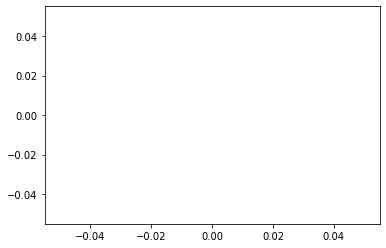

In [10]:
scores, n_iters = agent.train(NUM_EPISODES, MAX_ITERATIONS)
plt.plot(n_iters)

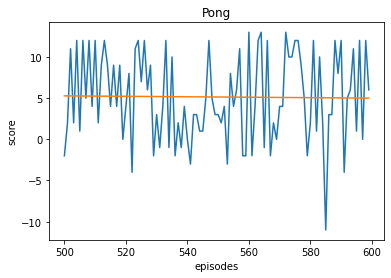

In [11]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import seaborn as sns

# sns.set()
x = range(INIT_EPISODE,NUM_EPISODES+INIT_EPISODE)
plt.plot(x,scores)
plt.ylabel('score')
plt.xlabel('episodes')
plt.title('Pong')

reg = LinearRegression().fit(np.arange(len(scores)).reshape(-1, 1), np.array(scores).reshape(-1, 1))
y_pred = reg.predict(np.arange(len(scores)).reshape(-1, 1))
plt.plot(x,y_pred)
plt.show()

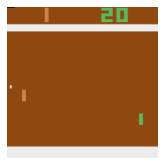

In [12]:
import cv2
def animate():
    frames = []
    state = env.reset()
    done = False
    while not done:
        frames.append(cv2.resize(env.render(mode='rgb_array'), (200, 200)))
        action = np.argmax(agent.model.predict(np.expand_dims(state,axis = 0)), axis=1)[0]
        state, _, done, _ = env.step(action)
    return frames
display.HTML(display_anim(animate(),fps = 24))